In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# configure matplotlib
%matplotlib notebook
# %matplotlib inline

In [3]:
from cdi.util.stats_utils import load_statistics

from cdi.util.analysis.plotting import plot_comparison, plot_chains
from cdi.util.analysis.logs import collate_stats, trace_data_chains

## Analysis setup

In [5]:
data_name = 'toy_set3'
exp_seed_key = 'm20190508_d20200325_20200406_20200407'

### Templates

In [6]:
log_path_template = f'../../trained_models/{data_name}/learning_experiments/{{}}/{{}}/{exp_seed_key}/logs/{{}}'

## Helpers

In [7]:
def read_experiment_stats(group, model):
    path = log_path_template.format(group, model, 'summary.csv')
    filename = os.path.basename(path)
    dirpath = os.path.dirname(path)
    return load_statistics(dirpath, filename)

def read_suite_stats(group, suite):
    return {
        name: read_experiment_stats(group, model)
        for name, model in suite.items()
    }

def read_all_suite_stats(groups, suite):
    return {
        group: read_suite_stats(group, suite)
        for group in groups
    }

## Analysis

### Learning curves

In [44]:
suite = {
#     'VCDI Test': 'fa_variational_cdi_test3',
    'pre-VCDI Test': 'fa_pretrained_var_cdi_1mis_3gibbs_test3'
}

<IPython.core.display.Javascript object>


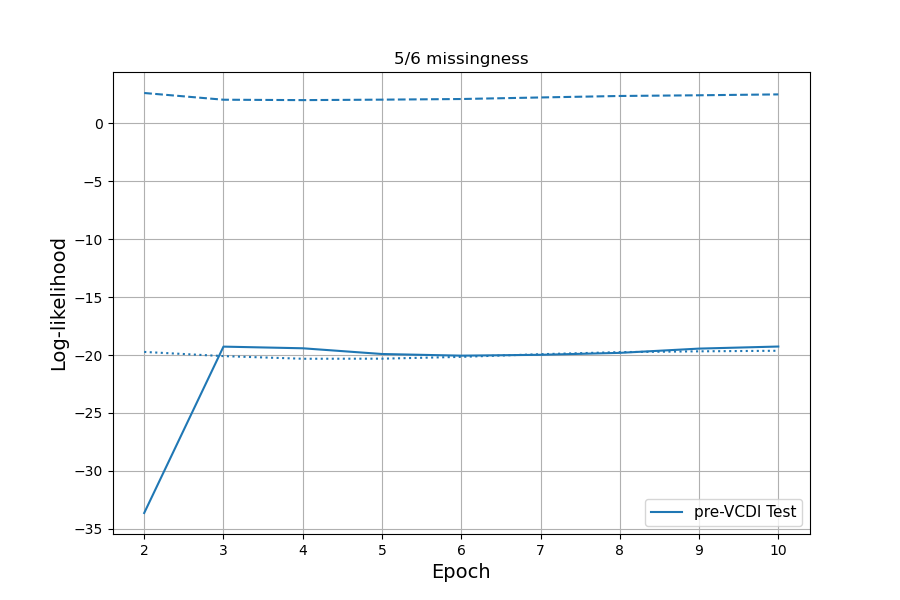

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(9, 6))
stats = read_suite_stats(group=3, suite=suite)

axes.set(title=f'5/6 missingness')
plot_comparison(axes, stats, 
                x_metric_key='curr_epoch',
#                 y_metric_keys=('val_log_lik',),  
#                 y_metric_keys=('train_entropy',),  
#                 y_metric_keys=('train_log_lik',), 
                y_metric_keys=('train_log_lik', 'train_entropy', 'val_log_lik'),# 'val_log_lik'),
                err_keys=(None, None, None,),
#                 err_keys=(None, None),
#                 err_keys=(None, ),
                xlabel='Epoch',
                ylabel='Log-likelihood', 
                ylim=None)
#                     ylim=(-22, -19))
#                     ylim=(-26, -17))


### Trace data chains with largest magnitudes at the end of training (crash)

In [71]:
indices_traced = np.array([0,      # For reference
#                            4552,   # Dim 0 topk
#                            27093,  # Dim 1 topk
#                            8352,   # Dim 2 topk
#                            36839,  # Dim 3 topk
#                            24281,  # Dim 4 topk
#                            31174],  # Dim 5 topk
                           37803, 15675, 37803, 28473, 10774,   481],
                          dtype=np.long)
group = 3
# model = 'fa_variational_cdi_test3'
model = 'fa_pretrained_var_cdi_1mis_3gibbs_test3'
chains = trace_data_chains(dirname=log_path_template.format(group, model, 'tensors'), 
                           logname='data',
                           indices=indices_traced)
# Show which values are observed
chains['M'][0]

array([[False, False, False, False, False,  True],
       [False, False, False,  True,  True,  True],
       [ True, False, False,  True, False,  True],
       [False, False, False,  True,  True,  True],
       [ True,  True, False, False,  True,  True],
       [ True,  True, False, False, False,  True],
       [False, False,  True, False,  True, False]])

<IPython.core.display.Javascript object>


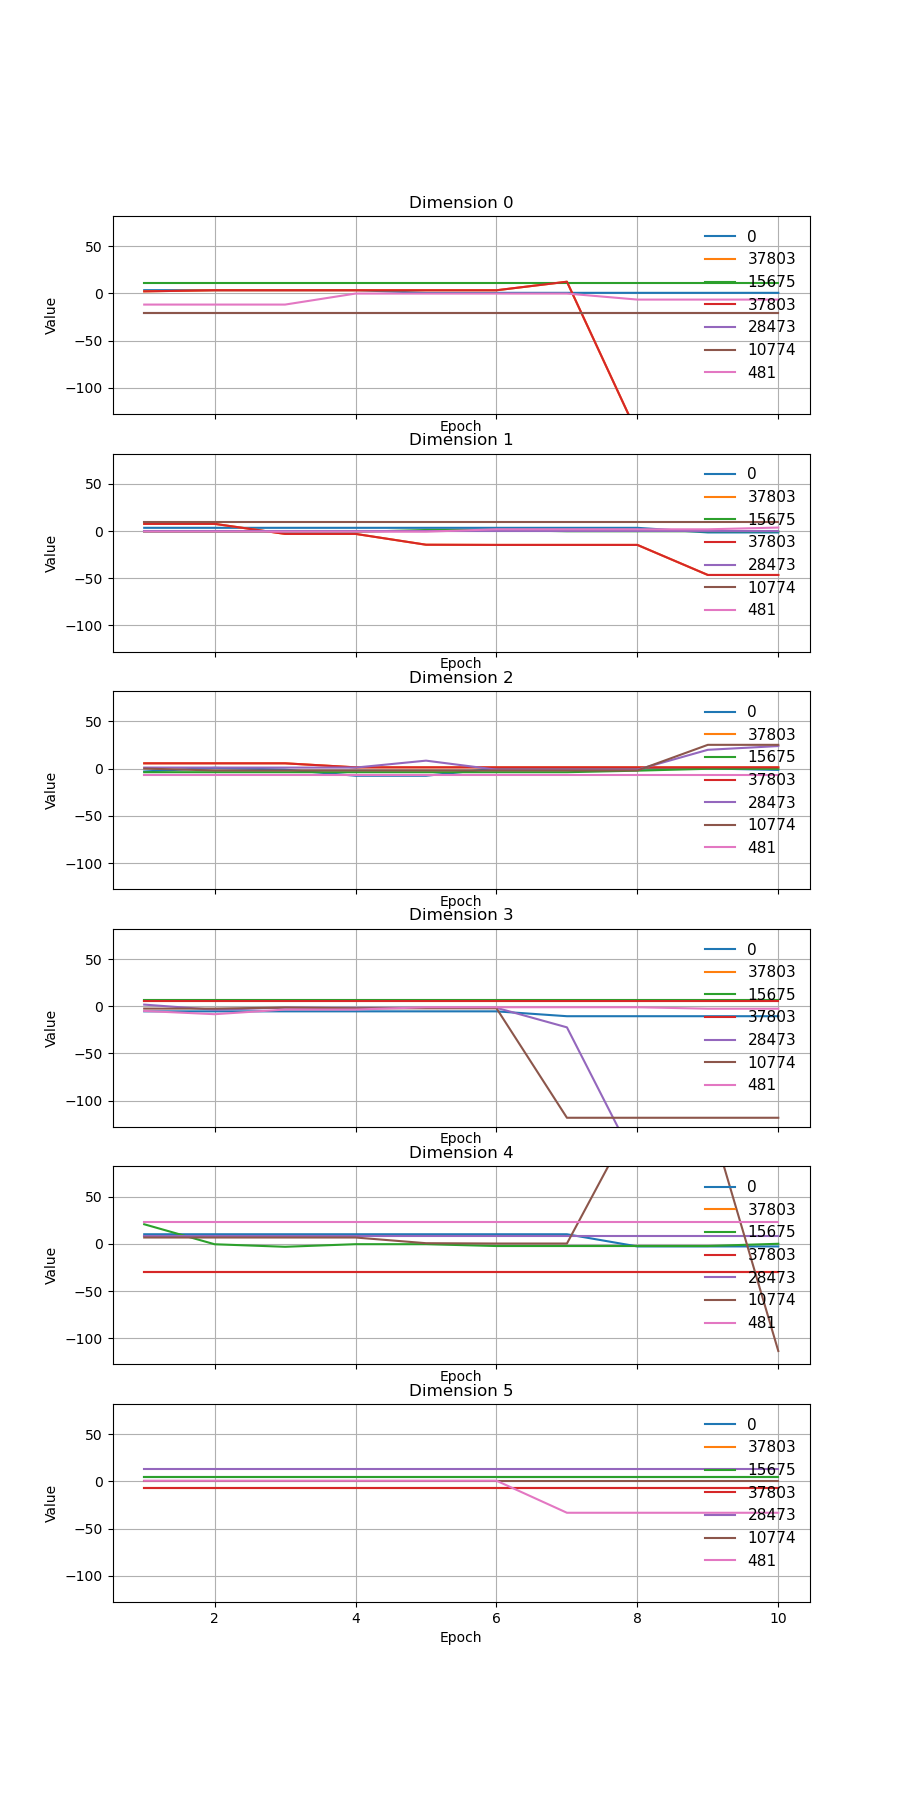

In [72]:
fig, axes = plt.subplots(nrows=chains['X'].shape[-1], ncols=1, sharex=True, sharey=True, figsize=(9, 18))
for i in range(chains['X'].shape[-1]):
    axes[i].set(title=f'Dimension {i}')
    plot_chains(axes[i], 
                epochs=chains['curr_epoch'], 
                chains=chains['X'][:, :, i], 
                labels=chains['I'][0, :],
                ylim=None)


<IPython.core.display.Javascript object>


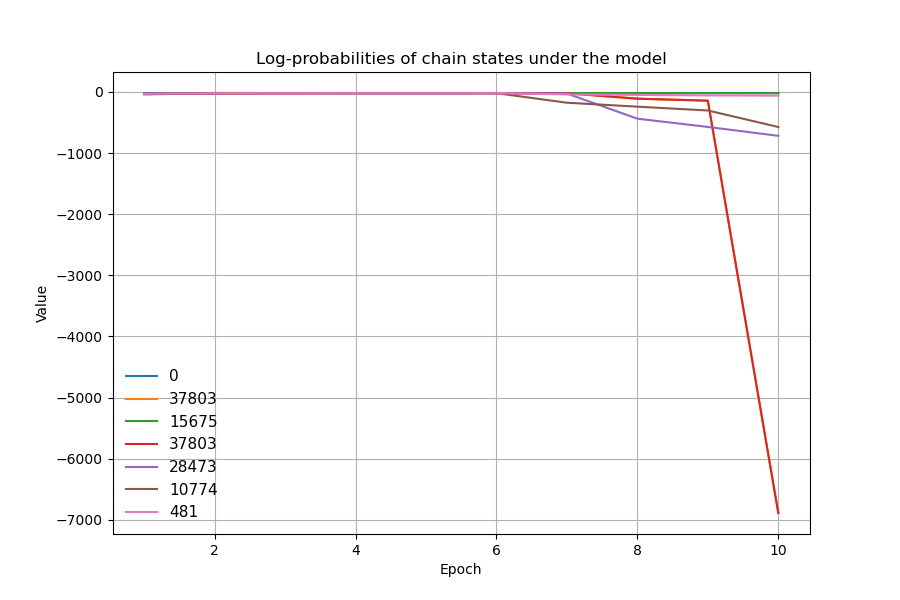

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(9, 6))

axes.set(title=f'Log-probabilities of chain states under the model')
plot_chains(axes, 
            epochs=chains['curr_epoch'], 
            chains=chains['P'], 
            labels=chains['I'][0, :],
            ylim=None)


In [40]:
# fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(9, 6))
# stats = read_suite_stats(group=3, suite=suite)

# axes.set(title=f'5/6 missingness')
# plot_comparison(axes, stats, 
#                 x_metric_key='curr_epoch',
#                 y_metric_keys=('train_log_lik', 'train_entropy', 'train_kldiv_0', 'train_kldiv_1', 'train_kldiv_2', 'train_kldiv_3', 'train_kldiv_4', 'train_kldiv_5'),
#                 err_keys=(None, None, None, None, None, None,None, None),
# #                 err_keys=(None, None),
# #                 err_keys=(None, ),
#                 xlabel='Epoch',
#                 ylabel='Log-likelihood', 
#                 ylim=None)
# #                     ylim=(-22, -19))
# #                     ylim=(-26, -17))


In [82]:
group = 3
model = 'fa_pretrained_var_cdi_1mis_3gibbs_test3'
var_params = trace_data_chains(dirname=log_path_template.format(group, model, 'tensors'), 
                               logname='var_params',
#                                epochs=chains['curr_epoch'][1:],
                               indices=np.array([37803], dtype=np.long))
# The indices of selected samples
var_params['I'][0]

array([37803], dtype=int32)

In [83]:
var_params['log_var'][var_params['log_var'] == float('-inf')] = 0

<IPython.core.display.Javascript object>


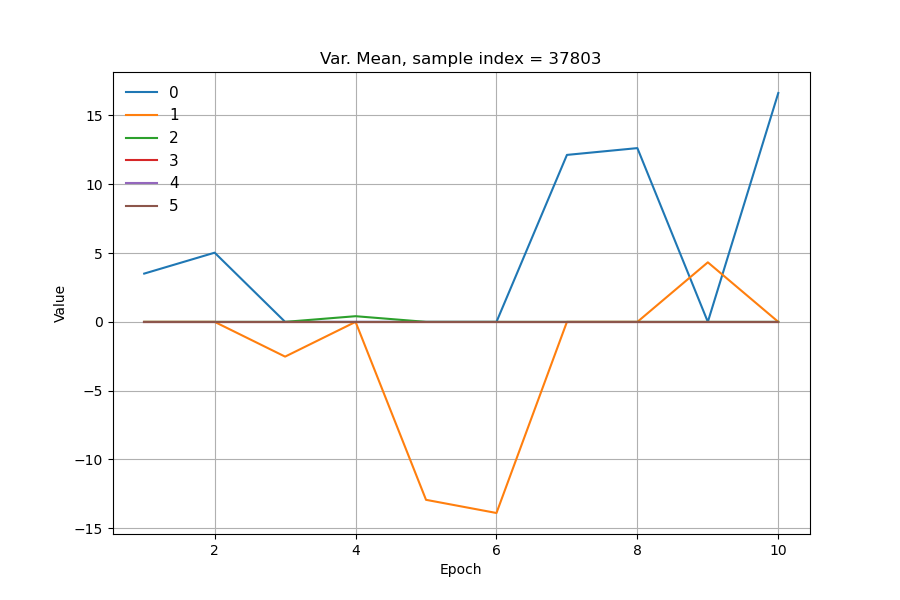

In [84]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(9, 6))

axes.set(title=f'Var. Mean, sample index = {var_params["I"][0, :].item()}')
plot_chains(axes, 
            epochs=var_params['curr_epoch'], 
            chains=var_params['mean'].squeeze(), 
            labels=list(np.arange(var_params['mean'].shape[-1])),
            ylim=None)


<IPython.core.display.Javascript object>


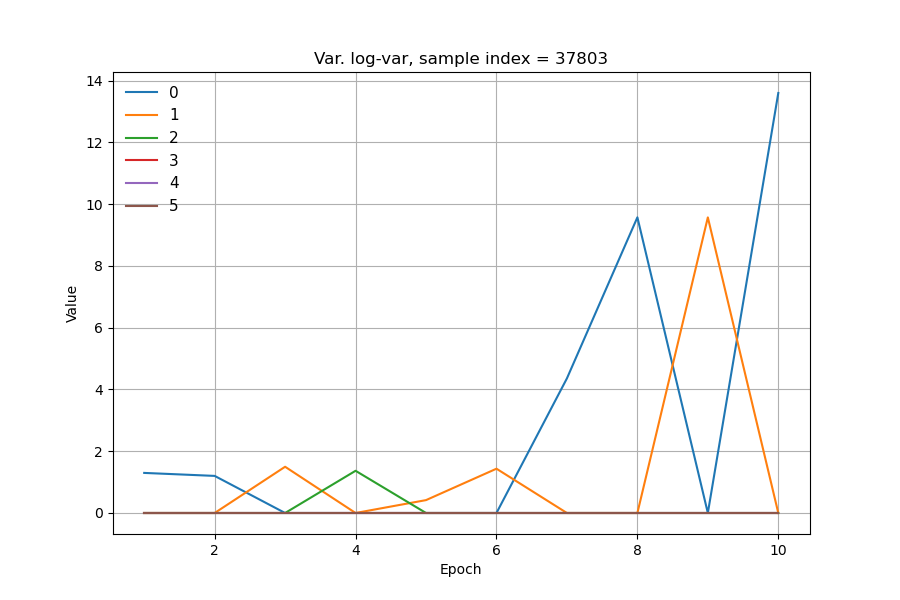

In [85]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(9, 6))

axes.set(title=f'Var. log-var, sample index = {var_params["I"][0, :].item()}')
plot_chains(axes, 
            epochs=var_params['curr_epoch'], 
            chains=var_params['log_var'].squeeze(), 
            labels=list(np.arange(var_params['mean'].shape[-1])),
            ylim=None)
